## Proyecto EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datasets
df_meta = pd.read_csv('./src/data/metacritic-games-data.csv')
df_sales = pd.read_csv('./src/data/vgsales.csv') # El nombre depende del que bajes

# Previsualización
df_meta.head()

,name,platform,r-date,score,user score,developer,genre,players,critics,users
0,The Legend of Zelda: Ocarina of Time,Nintendo64,"November 23, 1998",99,9.1,Nintendo,"Action Adventure,Fantasy",1 Player,22,5749
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",98,7.4,NeversoftEntertainment,"Sports,Alternative,Skateboarding",1-2,19,647
2,Grand Theft Auto IV,PlayStation3,"April 29, 2008",98,7.6,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,64,3806
3,SoulCalibur,Dreamcast,"September 8, 1999",98,8.5,Namco,"Action,Fighting,3D",1-2,24,324
4,Grand Theft Auto IV,Xbox360,"April 29, 2008",98,7.9,RockstarNorth,"Action Adventure,Modern,Modern,Open-World",1 Player,86,3364


In [5]:
# 1. Limpiar espacios en blanco en los nombres
df_meta['name'] = df_meta['name'].str.strip()
df_sales['Name'] = df_sales['Name'].str.strip()

# 2. Unir los DataFrames por nombre y plataforma
# Nota: A veces las plataformas se llaman distinto (ej: "PS4" vs "PlayStation 4"), 
# asegúrate de mapearlas si es necesario.
df_combined = pd.merge(df_meta, df_sales, left_on=['name', 'platform'], right_on=['Name', 'Platform'], how='inner')

# 3. Limpiar puntuaciones de usuario (Metacritic a veces tiene "tbd")
df_combined = df_combined[df_combined['user score'] != 'tbd']
df_combined['user score'] = df_combined['user score'].astype(float)

# 4. Escalar el User Score (0-10) a la misma escala que el Critic Score (0-100)
df_combined['user_score_100'] = df_combined['user score'] * 10

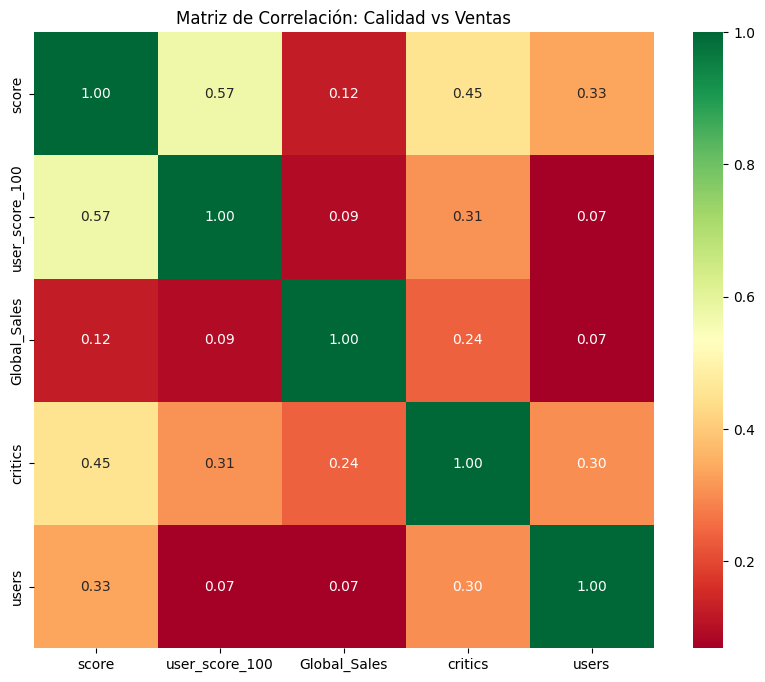

In [6]:
# Seleccionar columnas numéricas para correlación
cols_corr = ['score', 'user_score_100', 'Global_Sales', 'critics', 'users']
correlation_matrix = df_combined[cols_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Matriz de Correlación: Calidad vs Ventas')
plt.show()

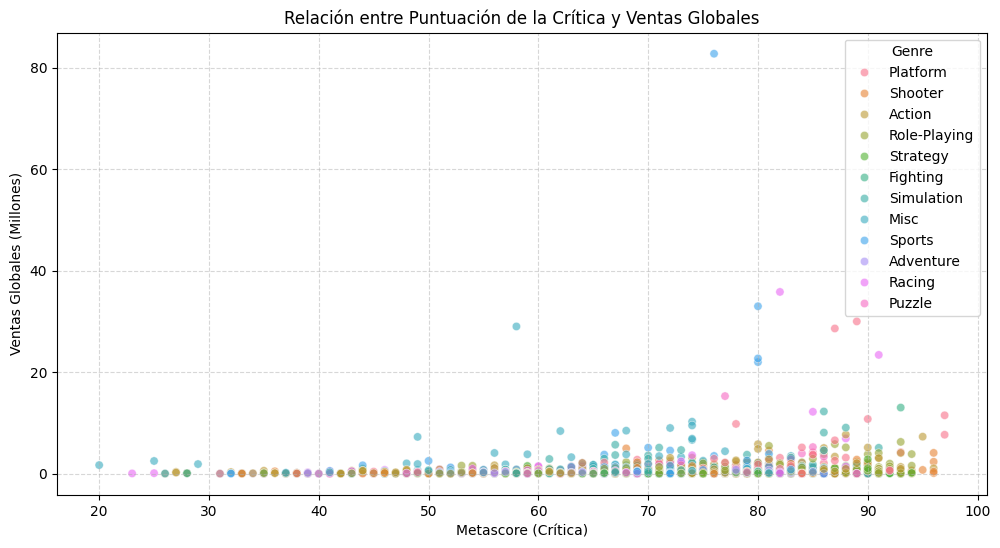

In [7]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_combined, x='score', y='Global_Sales', alpha=0.6, hue='Genre')
plt.title('Relación entre Puntuación de la Crítica y Ventas Globales')
plt.xlabel('Metascore (Crítica)')
plt.ylabel('Ventas Globales (Millones)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [8]:
# Calcular la diferencia (Prensa - Usuarios)
df_combined['opinion_gap'] = df_combined['score'] - df_combined['user_score_100']

# Top 10 juegos más "odiados" por el público pero amados por la prensa
polemicos = df_combined.sort_values(by='opinion_gap', ascending=False).head(10)
print(polemicos[['name', 'score', 'user_score_100', 'opinion_gap']])

                                name  score  user_score_100  opinion_gap
497              Company of Heroes 2     80            21.0         59.0
1105      Thrillville: Off the Rails     72            15.0         57.0
361            Football Manager Live     82            30.0         52.0
50         Tiger Woods PGA Tour 2005     91            39.0         52.0
1186  Call of Duty: Modern Warfare 3     70            20.0         50.0
654   Call of Duty: Modern Warfare 3     78            29.0         49.0
128                       Diablo III     88            41.0         47.0
1321            Call of Duty: Ghosts     68            22.0         46.0
508                   World of Tanks     80            35.0         45.0
1052                     Thrillville     72            28.0         44.0


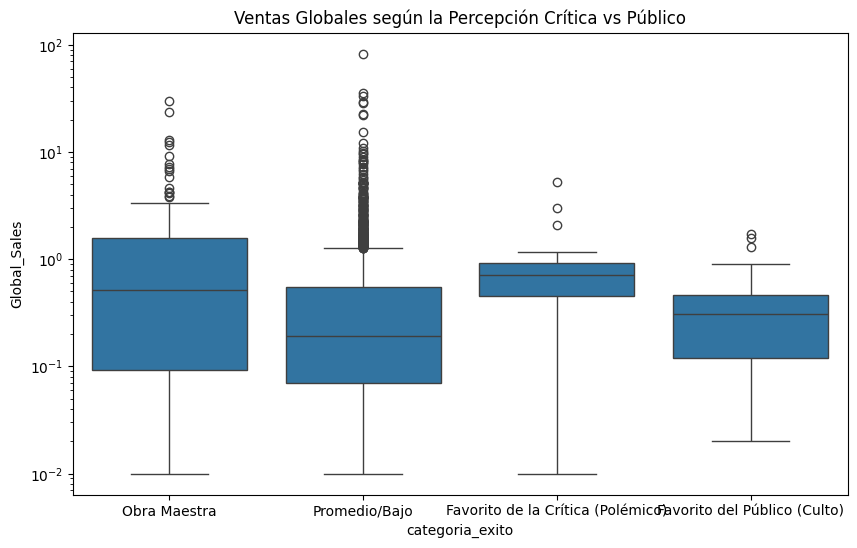

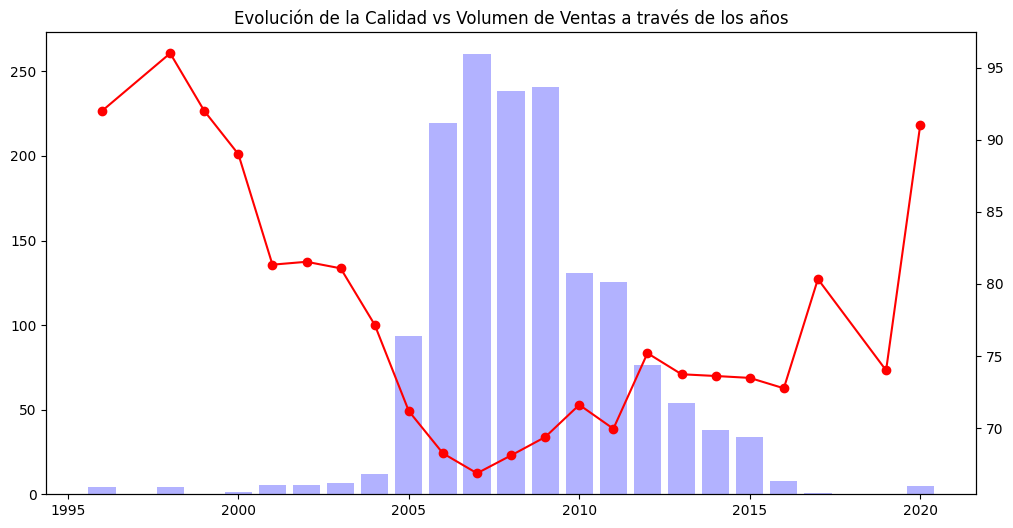

In [9]:
# --- CLASIFICACIÓN POR CUADRANTES ---
def clasificar_juego(row):
    if row['score'] >= 85 and row['user_score_100'] >= 85:
        return 'Obra Maestra'
    elif row['score'] >= 85 and row['user_score_100'] < 70:
        return 'Favorito de la Crítica (Polémico)'
    elif row['score'] < 70 and row['user_score_100'] >= 85:
        return 'Favorito del Público (Culto)'
    else:
        return 'Promedio/Bajo'

df_combined['categoria_exito'] = df_combined.apply(clasificar_juego, axis=1)

# Visualización de los Cuadrantes
plt.figure(figsize=(10,6))
sns.boxplot(x='categoria_exito', y='Global_Sales', data=df_combined)
plt.title('Ventas Globales según la Percepción Crítica vs Público')
plt.yscale('log') # Usamos escala logarítmica si hay mucha diferencia en ventas
plt.show()

# --- ANÁLISIS DE VENTAS POR DÉCADA ---
df_combined['year'] = pd.to_datetime(df_combined['r-date']).dt.year
ventas_tiempo = df_combined.groupby('year')['Global_Sales'].sum()
score_tiempo = df_combined.groupby('year')['score'].mean()

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.bar(ventas_tiempo.index, ventas_tiempo, alpha=0.3, color='blue', label='Ventas')
ax2.plot(score_tiempo.index, score_tiempo, color='red', marker='o', label='Calidad Media')
plt.title('Evolución de la Calidad vs Volumen de Ventas a través de los años')
plt.show()